In [ ]:
#install libraries

!pip install pycox torchtuples

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.9/412.9 kB 35.3 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2434 sha256=d8113a68ff1f46e179e551dfe67cbaf75435d688f005e7b838a4060450ce942e
  Stored in directory: /root/.cache/pip/wheels/77/5b/0e/0e63d10b6353208a085a321ea2eed2578f220a77bb8a4bd7ab
Successfully built feather-format


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
import torchtuples as tt
from torch.optim.lr_scheduler import ReduceLROnPlateau

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Practicum Models/survival_episodes_cleaned.csv')
df

,randid,start_date,duration,event_observed,NOAAClimRegion,TempZone,HumidZone,bin_PlantSize_kW,plant_age_months,active_snow_tickets,snow_bin_ticket_minutes,snow_affected_assets,snow_production_level,snow_value_mm,total_daily_snow_mm,low_irradiation,cumulative_snow_mm,hurr_bin_ticket_minutes,hurr_affected_assets,hurr_production_level,HurricanePrep,HurricanePostInspection,hurricane,nearest_hurricane,wind_speed_mean,rain_value_mm,nearest_rain,storm_active_tickets,storm_bin_ticket_minutes,storm_affected_assets,storm_production_level,lightning,storm,duration_minutes_storm,nearest_storm,flood,duration_minutes_flood,nearest_flood,rain,weather_onset
0,C2S1,2018-10-13,1,1,West,T6,H4,large,25.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,2.677792,0.017805,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
1,C2S1,2018-11-22,3,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.930521,1.136330,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
2,C2S1,2018-11-29,3,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,5.715604,8.015464,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
3,C2S1,2018-11-30,2,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,7.684687,0.239059,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
4,C2S1,2018-12-05,2,1,West,T6,H4,large,27.0,No,NaN,NaN,Unknown,0.0,0.0,1,0.0,NaN,NaN,Unknown,No,No,0.0,354,1.672604,0.396306,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7266,P2S1,2019-03-08,3,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.936458,0.425360,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7267,P2S1,2019-03-20,10,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,3.394271,1.412394,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7268,P2S1,2019-03-21,9,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.167917,3.042049,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1
7269,P2S1,2019-03-22,8,1,West,T1,H2,large,2.0,No,NaN,NaN,Unknown,0.0,0.0,0,0.0,NaN,NaN,Unknown,No,No,0.0,354,4.028187,0.000410,0,No,NaN,NaN,Unknown,0,0.0,0,2420,0.0,0,2255,1.0,1


In [ ]:
# Step 4: Prepare features and targets
X = df.drop(columns=['duration', 'event_observed', 'start_date', 'randid'], errors='ignore')
y_duration = df['duration'].values
y_event = df['event_observed'].values

# One-hot encode categorical variables
cat_cols = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Standardize numeric features and convert to float32 for PyTorch
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.astype('float32')

# Train-test split
X_train, X_test, y_train_duration, y_test_duration, y_train_event, y_test_event = train_test_split(
    X_scaled, y_duration, y_event, test_size=0.2, random_state=42
)


In [ ]:
X_train.shape, X_test.shape, y_train_duration.shape, y_test_duration.shape, y_train_event.shape, y_test_event.shape

((5816, 58), (1455, 58), (5816,), (1455,), (5816,), (1455,))

In [ ]:
y_train = (y_train_duration, y_train_event)
y_test = (y_test_duration, y_test_event)

In [ ]:
class DeepSurvNet(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.01),
            nn.BatchNorm1d(64),
            nn.Dropout(0.1),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)

in_features = X_train.shape[1]
net = DeepSurvNet(in_features)

In [ ]:
model = CoxPH(net, tt.optim.Adam)
model.optimizer.set_lr(1e-4)

callbacks = [tt.callbacks.EarlyStopping(patience=15)]

batch_size = 256
epochs = 512

In [ ]:
log = model.fit(X_train, y_train, batch_size, epochs,
                callbacks=callbacks, verbose=True, val_data=(X_test, y_test))

0:	[0s / 0s],		train_loss: 4.8688,	val_loss: 6.5385
1:	[0s / 0s],		train_loss: 4.7125,	val_loss: 6.4376
2:	[0s / 0s],		train_loss: 4.6501,	val_loss: 6.3747
3:	[0s / 0s],		train_loss: 4.6178,	val_loss: 6.3489
4:	[0s / 0s],		train_loss: 4.5973,	val_loss: 6.3311
5:	[0s / 0s],		train_loss: 4.5817,	val_loss: 6.3208
6:	[0s / 0s],		train_loss: 4.5656,	val_loss: 6.3069
7:	[0s / 0s],		train_loss: 4.5547,	val_loss: 6.2970
8:	[0s / 1s],		train_loss: 4.5424,	val_loss: 6.2885
9:	[0s / 1s],		train_loss: 4.5322,	val_loss: 6.2810
10:	[0s / 1s],		train_loss: 4.5265,	val_loss: 6.2755
11:	[0s / 1s],		train_loss: 4.5192,	val_loss: 6.2670
12:	[0s / 1s],		train_loss: 4.5115,	val_loss: 6.2616
13:	[0s / 1s],		train_loss: 4.5065,	val_loss: 6.2554
14:	[0s / 1s],		train_loss: 4.4958,	val_loss: 6.2513
15:	[0s / 1s],		train_loss: 4.4938,	val_loss: 6.2461
16:	[0s / 1s],		train_loss: 4.4910,	val_loss: 6.2428
17:	[0s / 1s],		train_loss: 4.4849,	val_loss: 6.2408
18:	[0s / 1s],		train_loss: 4.4816,	val_loss: 6.2398
19:

In [ ]:
model.compute_baseline_hazards()
surv = model.predict_surv_df(X_test)


In [ ]:
ev = EvalSurv(surv, y_test_duration, y_test_event, censor_surv='km')
print("DeepSurv C-index:", ev.concordance_td('antolini'))


DeepSurv C-index: 0.7719908896153147


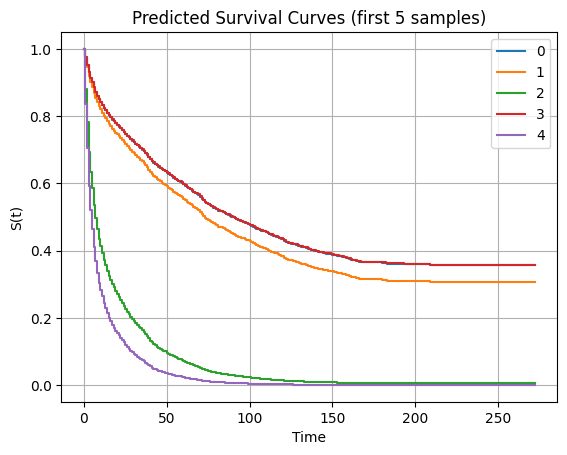

In [ ]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t)')
plt.xlabel('Time')
plt.title('Predicted Survival Curves (first 5 samples)')
plt.grid(True)
plt.show()